# Support Vector Machine experiment

In [1]:
%matplotlib inline

## Load data

In [2]:
from imbatcher.Decoder import Decoder


paths = ["/home/yordwynn/Image/screenshots/true/",
         "/home/yordwynn/Image/screenshots/false/"]
labels = [1, 0]
data = Decoder.decode_png_images(paths, labels, 0.4)
x_data = data["data"]
y_data = data["labels"]

## Show data

Print 5 positive and 5 negative random images

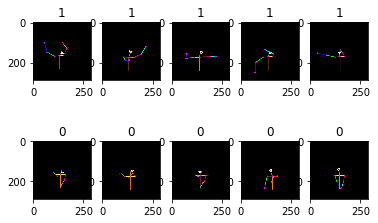

In [3]:
import numpy as np
import matplotlib.pyplot as plt

samples_per_class = 5
num_classes = len(labels)

y_data = np.array(y_data).reshape(-1)
x_data = np.array(x_data)

for y, item in enumerate(labels):
    idxs = np.flatnonzero(y_data == item)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        image = x_data[idxs[i]]
        image = image.reshape(288, 288, 3)
        label = y_data[idxs[i]]
        plt.subplot(num_classes, samples_per_class, i + 1 + y * samples_per_class)
        plt.imshow(image)
        plt.title(label)
        
plt.show()

## Tune SVM classifier

### Linear cernel

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedShuffleSplit


#c = np.logspace(-2, 10, 5)
c = np.arange(0.01,0.05,0.01)
c_count = len(c)

classifier = SVC(kernel="linear")
param_grid = {"C": c}
scoring = {"accuracy": make_scorer(accuracy_score),
           "recall": make_scorer(recall_score)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

gs = GridSearchCV(classifier, param_grid=param_grid, scoring=scoring,
                  cv=cv, refit='accuracy', return_train_score=True, iid=False)
gs.fit(x_data[257:357], y_data[257:357])

results = gs.cv_results_
best_params = gs.best_params_
best_score = gs.best_score_

print(best_params)
print(best_score)

{'C': 0.01}
0.74


#### Extract and reshape

In [37]:
keys = []
prep_result = {}

for score in scoring:
    keys.append("mean_test_%s" % (score))
    keys.append("mean_train_%s" % (score))
    keys.append("std_test_%s" % (score))
    keys.append("std_train_%s" % (score))
    keys.append("rank_test_%s" % (score))
    
for key in keys:
    res = results[key]
    prep_result[key] = res

#### Show plot

ValueError: Input passed into argument "'y1'"is not 1-dimensional.

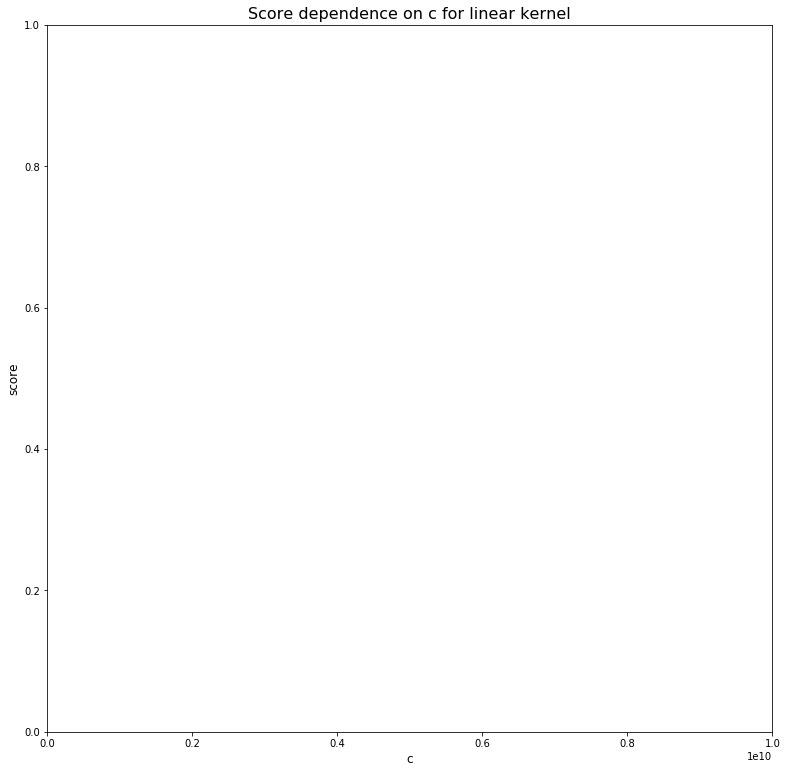

In [79]:
plt.figure(figsize=(13, 13))
plt.title("Score dependence on c for linear kernel",
          fontsize=16)

plt.xlabel("c", fontsize=12)
plt.ylabel("score", fontsize=12)

ax = plt.gca()
ax.set_xlim(1, c.max())
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(c, dtype=float)
    

for scorer, color in zip(sorted(scoring), ['g', 'k', 'b']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = prep_result['mean_%s_%s' % (sample, scorer)]
        sample_score_std = prep_result['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    rank_test = prep_result['rank_test_%s' % scorer]
    best_rank = rank_test.min()
    best_index = np.nonzero(rank_test == best_rank)[0][0]
    best_score = prep_result['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
        linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

### RBF kernel

In [48]:
c = np.logspace(-2, 10, 5)
c_count = len(c)

gamma = np.logspace(-15, 1, 5)
#gamma = ["auto", "scale"]
gamma_count = len(gamma)

classifier = SVC(kernel="rbf")
param_grid = {"C": c, "gamma": gamma}
scoring = {"accuracy": make_scorer(accuracy_score),
           "recall": make_scorer(recall_score)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

gs = GridSearchCV(classifier, param_grid=param_grid, scoring=scoring,
                  cv=cv, refit='accuracy', return_train_score=True, iid=False)
gs.fit(x_data[257:357], y_data[257:357])

results = gs.cv_results_
best_params = gs.best_params_
best_score = gs.best_score_

print(best_params)
print(best_score)

[1.00000000e-15 5.62341325e-12 3.16227766e-08 1.77827941e-04
 1.00000000e+00]
{'C': 10000.0, 'gamma': 5.6234132519034904e-12}
0.7


#### Extract and Reshape

In [49]:
keys = []
prep_result = {}

for score in scoring:
    keys.append("mean_test_%s" % (score))
    keys.append("mean_train_%s" % (score))
    keys.append("std_test_%s" % (score))
    keys.append("std_train_%s" % (score))
    keys.append("rank_test_%s" % (score))
    
for key in keys:
    res = results[key]
    res = res.reshape((c_count, gamma_count))
    prep_result[key] = res

#### Heatmap

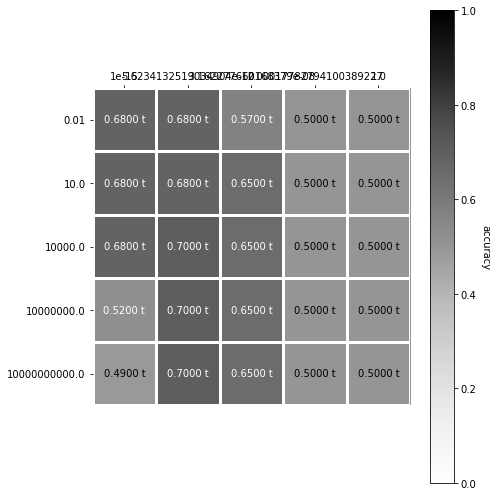

In [50]:
from heat_map import heatmap, annotate_heatmap

heatmap_metric = "accuracy"
mean_test_score = prep_result["mean_test_%s" % (heatmap_metric)]

plt.rcParams["figure.figsize"]=[7, 7]
fig, ax = plt.subplots()

im, cbar = heatmap(mean_test_score, c, gamma, ax=ax, cmap="Greys", vmin=0, vmax=1, cbarlabel=heatmap_metric)
texts = annotate_heatmap(im, valfmt="{x:.4f} t", textcolors=["black", "white"], threshold=0.5)

fig.tight_layout()
plt.show()

### Sigmoid kernel

In [54]:
c = np.logspace(-2, 10, 5)
c_count = len(c)

#gamma = np.logspace(-15, 1, 5)
gamma = ["auto", "scale"]
gamma_count = len(gamma)

classifier = SVC(kernel="sigmoid")
param_grid = {"C": c, "gamma": gamma}
scoring = {"accuracy": make_scorer(accuracy_score),
           "recall": make_scorer(recall_score)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

gs = GridSearchCV(classifier, param_grid=param_grid, scoring=scoring,
                  cv=cv, refit='accuracy', return_train_score=True, iid=False)
gs.fit(x_data[257:357], y_data[257:357])

results = gs.cv_results_
best_params = gs.best_params_
best_score = gs.best_score_

print(best_params)
print(best_score)

{'C': 10000000.0, 'gamma': 'auto'}
0.53


#### Extract and reshape

In [55]:
keys = []
prep_result = {}

for score in scoring:
    keys.append("mean_test_%s" % (score))
    keys.append("mean_train_%s" % (score))
    keys.append("std_test_%s" % (score))
    keys.append("std_train_%s" % (score))
    keys.append("rank_test_%s" % (score))
    
for key in keys:
    res = results[key]
    res = res.reshape((c_count, gamma_count))
    prep_result[key] = res

#### Heatmap

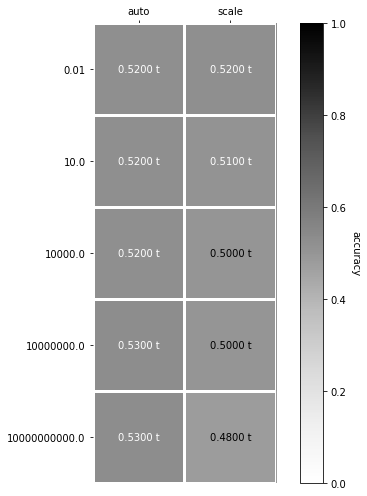

In [56]:
heatmap_metric = "accuracy"
mean_test_score = prep_result["mean_test_%s" % (heatmap_metric)]

plt.rcParams["figure.figsize"]=[7, 7]
fig, ax = plt.subplots()

im, cbar = heatmap(mean_test_score, c, gamma, ax=ax, cmap="Greys", vmin=0, vmax=1, cbarlabel=heatmap_metric)
texts = annotate_heatmap(im, valfmt="{x:.4f} t", textcolors=["black", "white"], threshold=0.5)

fig.tight_layout()
plt.show()

### Polynomial kernel

In [115]:
c = np.logspace(-2, 10, 5)
c_count = len(c)

gamma = np.logspace(-15, 1, 5)
#gamma = ["auto", "scale"]
gamma_count = len(gamma)

degree = range(2, 8)
degree_count = len(degree)

classifier = SVC(kernel="poly")
param_grid = {"C": c, "gamma": gamma, "degree": degree}
scoring = {"accuracy": make_scorer(accuracy_score),
           "recall": make_scorer(recall_score)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

gs = GridSearchCV(classifier, param_grid=param_grid, scoring=scoring,
                  cv=cv, refit='accuracy', return_train_score=True, iid=False)
gs.fit(x_data[257:357], y_data[257:357])

results = gs.cv_results_
best_params = gs.best_params_
best_score = gs.best_score_

print(best_params)
print(best_score)
print(results)

KeyboardInterrupt: 

#### Besr parameters's indexes

In [63]:
best_gamma_id = np.where(gamma == best_params["gamma"])
best_c_id = np.where(c == best_params["C"])

#### Extract and reshape results

In [101]:
keys = []
prep_result = {}

for score in scoring:
    keys.append("mean_test_%s" % (score))
    keys.append("mean_train_%s" % (score))
    keys.append("std_test_%s" % (score))
    keys.append("std_train_%s" % (score))
    keys.append("rank_test_%s" % (score))
    
for key in keys:
    res = results[key]
    res = res.reshape(c_count, degree_count, gamma_count)
    res = res.transpose(2, 0, 1)
    prep_result[key] = res

#### Show heatmap

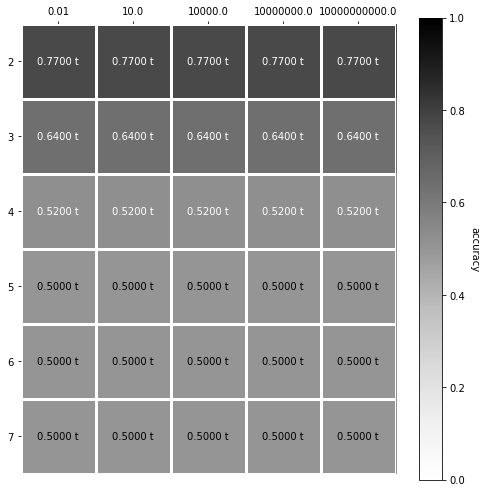

In [107]:
heatmap_metric = "accuracy"
mean_test_score = prep_result["mean_test_%s" % (heatmap_metric)][best_gamma_id][0]
mean_test_score = mean_test_score.transpose(1, 0)

plt.rcParams["figure.figsize"]=[7, 7]
fig, ax = plt.subplots()

im, cbar = heatmap(mean_test_score, degree, c, ax=ax, cmap="Greys", vmin=0, vmax=1, cbarlabel=heatmap_metric)
texts = annotate_heatmap(im, valfmt="{x:.4f} t", textcolors=["black", "white"], threshold=0.5)

fig.tight_layout()
plt.show()

#### Show plot poly kernel

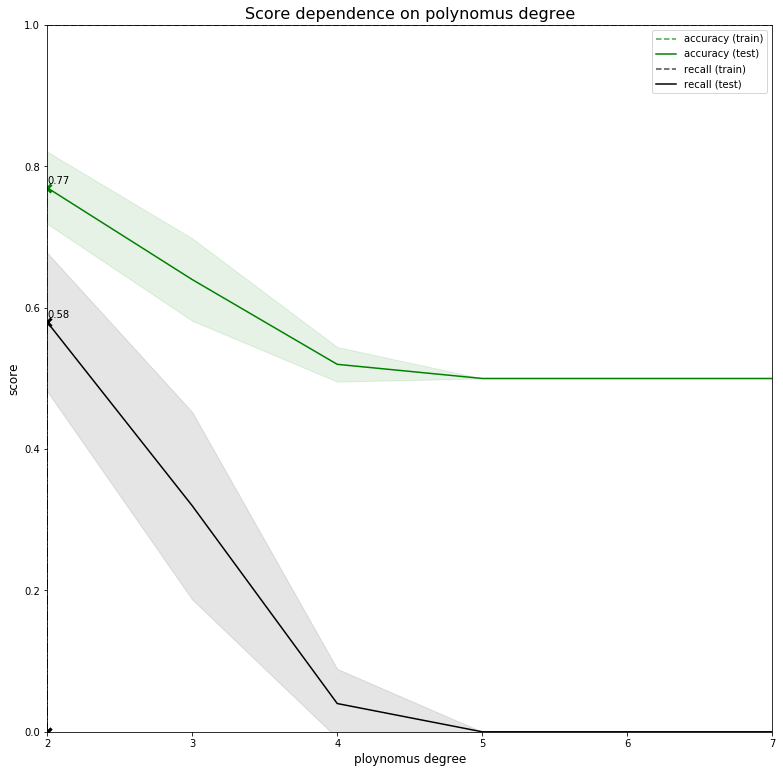

In [117]:
plt.figure(figsize=(13, 13))
plt.title("Score dependence on polynomus degree",
          fontsize=16)

plt.xlabel("ploynomus degree", fontsize=12)
plt.ylabel("score", fontsize=12)

ax = plt.gca()
ax.set_xlim(2, 7)
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(degree, dtype=int)
    

for scorer, color in zip(sorted(scoring), ['g', 'k', 'b']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = prep_result['mean_%s_%s' % (sample, scorer)][best_gamma_id][0][best_c_id][0]
        sample_score_std = prep_result['std_%s_%s' % (sample, scorer)][best_gamma_id][0][best_c_id][0]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    rank_test = prep_result['rank_test_%s' % scorer][best_gamma_id][0][best_c_id][0]
    best_rank = rank_test.min()
    best_index = np.nonzero(rank_test == best_rank)[0][0]
    best_score = prep_result['mean_test_%s' % scorer][best_gamma_id][0][best_c_id][0][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
        linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()